In [ ]:
# Get game and player data
import requests
import pandas as pd
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days) + 1):
        yield start_date + timedelta(n)

def get_sportsdata_io_data(start_date, end_date):
    base_url = "https://api.sportsdata.io/v4/soccer"
    api_key = "b1c341e1840e41e892f2c4fa1521fe06"

    for single_date in daterange(start_date, end_date):
        formatted_date = single_date.strftime("%Y-%m-%d")

        # Games by Date
        games_by_date_url = f"{base_url}/stats/json/GamesByDate/EPL/{formatted_date}?key={api_key}"
        games_by_date_response = requests.get(games_by_date_url)
        games_by_date_data = games_by_date_response.json()
        games_by_date_df = pd.DataFrame(games_by_date_data)

        # Append game data to a CSV file
        with open("games_by_date_range.csv", "a", newline="") as file:
            games_by_date_df.to_csv(file, index=False, header=not file.tell())

        # Player Game Stats
        player_game_url = f"{base_url}/stats/json/PlayerGameStatsByDate/EPL/{formatted_date}?key={api_key}"
        player_game_response = requests.get(player_game_url)
        player_game_data = player_game_response.json()
        player_game_df = pd.DataFrame(player_game_data)

        # Append player stats to a CSV file
        with open("player_game_stats_range.csv", "a", newline="") as file:
            player_game_df.to_csv(file, index=False, header=not file.tell())

# Specify start_date and end_date
start_date = date(2023, 8, 12)
end_date = date(2023, 11, 30)

# Call the function
get_sportsdata_io_data(start_date, end_date)


In [ ]:
# Get Team data
import requests
import pandas as pd
from datetime import datetime, timedelta

def get_sportsdata_io_data(start_date, end_date):
    base_url = "https://api.sportsdata.io/v4/soccer"
    api_key = "b1c341e1840e41e892f2c4fa1521fe06"

    current_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    while current_date <= end_date:
        formatted_date = current_date.strftime("%Y-%m-%d")

        # Team Game Stats
        team_game_stats_url = f"{base_url}/scores/json/TeamGameStatsByDate/EPL/{formatted_date}?key={api_key}"
        team_game_stats_response = requests.get(team_game_stats_url)
        team_game_stats_data = team_game_stats_response.json()

        if team_game_stats_data:
            team_game_stats_df = pd.DataFrame(team_game_stats_data)
            team_game_stats_df.to_csv("team_game_stats.csv", mode='a', header=not current_date, index=False)

        current_date += timedelta(days=1)

# Specify start_date and end_date
start_date = '2023-08-12'
end_date = '2023-11-30'

# Call the function
get_sportsdata_io_data(start_date, end_date)


In [2]:
import pandas as pd

# Load the CSV files
games_df = pd.read_csv('games_by_date_range.csv')
team_stats_df = pd.read_csv('team_game_stats.csv')

# Merge the tables on the 'GameId' column
merged_data = pd.merge(games_df, team_stats_df, on='GameId', how='inner')

# Save the merged data to a new CSV file
merged_data.to_csv('merged_data.csv', index=False)


In [3]:
merged_data.info()
print(merged_data.describe())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 258 entries, 0 to 257
Columns: 113 entries, GameId to Tackles
dtypes: bool(2), float64(53), int64(34), object(24)
memory usage: 226.3+ KB
             GameId  RoundId_x  Season_x  SeasonType_x  Group   AwayTeamId  \
count    258.000000      258.0     258.0         258.0    0.0   258.000000   
mean   62515.000000     1115.0    2024.0           1.0    NaN   959.193798   
std       37.310351        0.0       0.0           0.0    NaN   613.154655   
min    62451.000000     1115.0    2024.0           1.0    NaN   508.000000   
25%    62483.000000     1115.0    2024.0           1.0    NaN   513.000000   
50%    62515.000000     1115.0    2024.0           1.0    NaN   524.000000   
75%    62547.000000     1115.0    2024.0           1.0    NaN  1463.000000   
max    62579.000000     1115.0    2024.0           1.0    NaN  2195.000000   

        HomeTeamId      VenueId        Week  Clock  ...  \
count   258.000000   258.000000  258.000000    0.0

In [4]:
# Check for missing values
print(merged_data.isnull().sum())



GameId                 0
RoundId_x              0
Season_x               0
SeasonType_x           0
Group                258
                    ... 
PenaltiesWon           0
PenaltiesConceded      0
Score                  0
OpponentScore          0
Tackles                0
Length: 113, dtype: int64


In [5]:
# Check for NaN values in each column
nan_values = merged_data.isnull().sum()

# Display columns with NaN values and their counts
columns_with_nan = nan_values[nan_values > 0]
print(columns_with_nan)


Group                     258
Clock                     258
AwayTeamScoreExtraTime    258
AwayTeamScorePenalty      258
HomeTeamScoreExtraTime    258
HomeTeamScorePenalty      258
Attendance                  2
ClockExtra                258
ClockDisplay              258
PlayoffAggregateScore     258
FantasyPointsFanDuel      258
FantasyPointsYahoo        258
dtype: int64


In [6]:
# Drop columns with too many NaNs
columns_to_drop = ['Group', 'Clock', 'AwayTeamScoreExtraTime', 'AwayTeamScorePenalty',
                   'HomeTeamScoreExtraTime', 'HomeTeamScorePenalty', 'ClockExtra',
                   'ClockDisplay', 'PlayoffAggregateScore', 'FantasyPointsFanDuel',
                   'FantasyPointsYahoo','Winner', 'Status']
merged_data = merged_data.drop(columns=columns_to_drop)


In [7]:


# Replace the Winner column with encoded values
merged_data['Winner'] = 'Draw'  # Initialize all matches as draws

# Set the winner based on scores
merged_data.loc[merged_data['AwayTeamScore'] > merged_data['HomeTeamScore'], 'Winner'] = 'AwayWin'  # Away win
merged_data.loc[merged_data['AwayTeamScore'] < merged_data['HomeTeamScore'], 'Winner'] = 'HomeWin'  # Home win

# Map 'Draw' to 'AwayWin' or 'HomeWin' based on your criteria
merged_data['Winner'] = merged_data['Winner'].apply(lambda x: 'HomeWin' if x == 'Draw' else x)

# Drop unnecessary columns used for calculations
merged_data = merged_data.drop(['AwayTeamScore', 'HomeTeamScore'], axis=1)



In [8]:
merged_data['Winner']

0      HomeWin
1      HomeWin
2      HomeWin
3      HomeWin
4      HomeWin
        ...   
253    AwayWin
254    AwayWin
255    AwayWin
256    HomeWin
257    HomeWin
Name: Winner, Length: 258, dtype: object

In [9]:
# Example for a categorical variable 'HomeOrAway'
merged_data['HomeOrAway'].value_counts()

AWAY    129
HOME    129
Name: HomeOrAway, dtype: int64

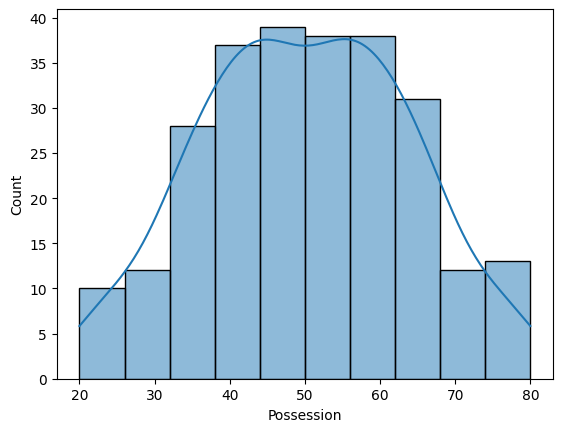

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Histogram for a numerical variable 'Possession'
sns.histplot(merged_data['Possession'], kde=True)
plt.show()

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load the merged data
merged_data_df = merged_data

# Feature selection (include 'Winner' in features)
features = merged_data_df[['RoundId_x', 'AwayTeamId', 'HomeTeamId', 'VenueId', 'Week', 'OverUnder',
                            'Attendance', 'Goals', 'DefenderCleanSheets', 'Assists', 'Shots',
                            'ShotsOnGoal', 'YellowCards', 'RedCards', 'Passes', 'PassesCompleted',
                            'CornersWon', 'Touches', 'GoalkeeperSaves', 'Winner']]

# Drop rows with missing 'Winner' values
features = features.dropna(subset=['Winner'])

# Separate features and target variable
X = features.drop('Winner', axis=1)
y = features['Winner']

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_imputed = imputer.fit_transform(X)

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the 'Winner' column
y_encoded = label_encoder.fit_transform(y)
print(y_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_encoded, test_size=0.2, random_state=42)

# Initialize the logistic regression model
model = LogisticRegression(max_iter=10000)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'Model Accuracy: {accuracy}')

# Display the coefficients for each feature
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
print(coefficients)


[1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1
 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0
 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1]
Model Accuracy: 0.8269230769230769
                Feature  Coefficient
0             RoundId_x     0.000333
1            AwayTeamId     0.001072
2            HomeTeamId     0.000678
3               VenueId    -0.000713
4                  Week     0.026346
5             OverUnder    -0.222710
6            Attendance     0.000018
7                 Goals     0.027868
8   DefenderCleanSheets    -0.127587
9               Assists    -0.054855
10                Shots     0.0395

In [12]:
def predict_winner_probability(home_team, away_team, model, label_encoder, imputer):
    # Convert team names to 'AwayTeamId' and 'HomeTeamId'
    away_team_id = merged_data_df.loc[merged_data_df['AwayTeamName'] == away_team, 'AwayTeamId'].iloc[0]
    home_team_id = merged_data_df.loc[merged_data_df['HomeTeamName'] == home_team, 'HomeTeamId'].iloc[0]

    # Create a DataFrame for the input teams
    teams_df = pd.DataFrame({
        'RoundId_x': [0],  # Replace with the appropriate value
        'AwayTeamId': [away_team_id],
        'HomeTeamId': [home_team_id],
        'VenueId': [1329],  # Replace with the appropriate value
        'Week': [25],  # Replace with the appropriate value
        'OverUnder': [0],  # Replace with the appropriate value
        'Attendance': [0],  # Replace with the appropriate value
        'Goals': [0],  # Replace with the appropriate value
        'DefenderCleanSheets': [0],  # Replace with the appropriate value
        'Assists': [0],  # Replace with the appropriate value
        'Shots': [0],  # Replace with the appropriate value
        'ShotsOnGoal': [0],  # Replace with the appropriate value
        'YellowCards': [0],  # Replace with the appropriate value
        'RedCards': [0],  # Replace with the appropriate value
        'Passes': [0],  # Replace with the appropriate value
        'PassesCompleted': [0],  # Replace with the appropriate value
        'CornersWon': [0],  # Replace with the appropriate value
        'Touches': [0],  # Replace with the appropriate value
        'GoalkeeperSaves': [0],  # Replace with the appropriate value
        'Winner': [0],  # The actual winner doesn't matter for prediction
    })

    # Impute missing values
    features_imputed = imputer.transform(teams_df.drop('Winner', axis=1))

    # Make predictions using the model
    predictions = model.predict_proba(features_imputed)

    # Decode numeric labels back to team names
    predicted_winner_label = label_encoder.inverse_transform(model.classes_)[1]  # Assuming class 1 is the winner
    predicted_winner_probability = predictions[0][1]  # Probability of winning

    return predicted_winner_label, predicted_winner_probability

# Example usage:
home_team_input = 'Arsenal FC'
away_team_input = 'Manchester United FC'

try:
    winner, probability = predict_winner_probability(home_team_input, away_team_input, model, label_encoder, imputer)
    print(f"Predicted Winner: {winner} with Probability: {probability:.2%}")
except ValueError as e:
    print(f"Error: {e}")




Predicted Winner: HomeWin with Probability: 64.81%


In [1]:
def predict_winner_probability(home_team, away_team, model, label_encoder, imputer):
    teams_df = merged_data_df[
        (merged_data_df['HomeTeamName'].isin([home_team, away_team])) &
        (merged_data_df['AwayTeamName'].isin([home_team, away_team]))
    ]

    # Check if there are any rows in the filtered DataFrame
    if teams_df.empty:
        raise ValueError(f"No data available for teams: {home_team} and {away_team}")

    # Drop irrelevant columns and handle missing values
    features = teams_df.drop(['Winner'], axis=1)  # Adjust columns accordingly
    features_imputed = imputer.transform(features)

    # Make predictions using the model
    predicted_probabilities = model.predict_proba(features_imputed)

    # Decode numeric labels back to team names
    predicted_winner_probabilities = list(zip(label_encoder.classes_, predicted_probabilities[0]))

    # Sort by probabilities in descending order
    predicted_winner_probabilities.sort(key=lambda x: x[1], reverse=True)

    return predicted_winner_probabilities
